<a href="https://colab.research.google.com/github/sisrel/EE214-Practice-Materials/blob/main/Practice-Fall2023/%5BProject_3%5D_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Project 3] Recurrent Neural Networks

This project consists of two parts. In the first half, we will try to **implement multiple types of RNN from scratch**. In the second half, we will actually **train an RNN and test** how well they work.  

Below are the detailed contents for this project:  

  * Part 1 (25 pts). Multiple types of RNN
  * Part 2 (30 pts). Enigma decrypt: Classifier  
  * Part 3 (30 pts). Enigma decrypt: Decipherer
  * Part 4 (15 pts). Enigma decryptor

##**Important**  
* You have to write some descriptions of codes and results for your points in each part. For required sections, we will make the **markdown** box to write in and inform you what to write. Check **ALL** steps that have points.  
* Training takes a few hours. We recommend you start early.  Also, use your time wisely, e.g., check for errors by executing the cells individually before running the entire code.
* We highly recommend you to **use GPU**. (`runtime` > `runtime type change` > `GPU`)
* **Submit** the completed Colab file and its pdf version on the KLMS. Their file names should be:  
  * **[STUDENT_ID]_project3.ipynb**, e.g., 20XXXXXX_project3.ipynb
  * **[STUDENT_ID]_project3.pdf**

#**Part 1 (Total 25 pts)**. Multiple types of RNN  

In the part 1-6, you will test all your models. You should get 27 passes to get max points, as shown below.  

<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/pass.JPG" width="70%"/>
<br/>
</p>

If you have made some mistakes, you might get a result like the figure below. `F` indicates failed task, and `.` indicates passed task.  
<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/fail.JPG" width="70%"/>
<br/>
</p>

## Building an RNN

### Part 1-1 (Total 5 pts). Recurrent Neural Network

<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/LSTM3-SimpleRNN.png" width="70%"/>
<br/>
<em>Figure from <a href="https://colah.github.io/about.html">Christopher Olah</a>'s blog <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">post</a>.</em>
</p>

Recall the update equation for an RNN.

$$h^{(t)}=\tanh(Wh^{(t-1)}+Ux^{(t)}+b)$$

You have **two tasks** to do:  

1. **Complete the skeleton code** given below using the equation above. You only need to rewrite the **`forward`** method. **Do not modify the methods `__init__` and `copy_from_torch`**. Feel free to implement additional helper functions if you need them.
2. Explain how RNN works **briefly** (e.g., meaning of the update equations, role of intermediate variables)

In [ ]:
%%file my_rnn_cell.py
import torch
from torch import Tensor, nn


class MyRNNCell(nn.Module):
    """ An RNN cell with tanh nonlinearity

    Parameters:
     - input_size(int): The number of expected features in the input x
     - hidden_size(int): The number of features in the hidden state h
    """
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super().__init__()
        self.W = nn.Parameter(torch.empty((hidden_size, hidden_size)))
        self.U = nn.Parameter(torch.empty((hidden_size, input_size)))
        self.b = nn.Parameter(torch.empty((hidden_size,)))

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        """Compute the next hidden state.

        Parameters:
         - x: tensor containing input features
         - h: tensor containing the initial hidden state

        Returns:
        tensor containing the next hidden state for each element in the batch

        Shape:
         - x: (batch_size, input_size)
         - h: (batch_size, hidden_size)
         - output: (batch_size, hidden_size)
        """
        ############################################
        ################# Part 1-1 #################
        hidden = nn.Tanh()(torch.matmul(h, self.W.t()) + torch.matmul(x, self.U.t()) + self.b)

        return hidden
        ############################################
        ############################################

    def copy_from_torch(self, module: nn.RNNCell):
        """Copy the parameters from the given nn.RNNCell module."""
        # nn.RNNCell's weight_hh is W
        # nn.RNNCell's weight_ih is U
        # the sum of nn.RNNCell's bias_hh and bias_ih is b
        self.W.data[:] = module.weight_hh
        self.U.data[:] = module.weight_ih
        if module.bias:
            self.b.data[:] = module.bias_hh + module.bias_ih
        else:
            nn.init.zeros_(self.b)

Writing my_rnn_cell.py


#### **Write explanation here**

RNN은 hidden layer에서 나온 결과값을 activation function에 넣어 나온 결과를 output layer에 보내 다시 다음 hidden layer 노드 계산의 입력값으로 보내는 방식이다. hidden layer는 현재 단계의 입력과 이전 단계의 hidden layer를 통해서 update 되며 최종 outuput은 마지막 hidden layer를 통해서 출력된다.이전 hidden layer를 계산에 포함하므로 이전 정보를 반영할 수 있게 된다.

### Part 1-2 (Total 5 pts).  LSTM (Long Short-Term Memory)

<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/LSTM3-chain.png" width="70%"/>
<br/>
<em>Figure from <a href="https://colah.github.io/about.html">Christopher Olah</a>'s blog <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">post</a>.</em>
</p>

Recall the update equations of an LSTM.

$$
\begin{align*}
    f^{(t)}
    &=\sigma(W_fh^{(t-1)}+U_fx^{(t)}+b_f)\\
    g^{(t)}
    &=\sigma(W_gh^{(t-1)}+U_gx^{(t)}+b_g)\\
    q^{(t)}
    &=\sigma(W_oh^{(t-1)}+U_ox^{(t)}+b_o)\\
    \tilde{s}^{(t)}
    &=\tanh(Wh^{(t-1)}+Ux^{(t)}+b)\\
    s^{(t)}
    &=f^{(t)}\odot s^{(t-1)}+g^{(t)}\odot\tilde{s}^{(t)}\\
    h^{(t)}
    &=q^{(t)}\odot \tanh(s^{(t)})
\end{align*}
$$

Note that we use the $\tanh$ nonlinearity to compute the next state in the fourth equation instead of the sigmoid nonlinearity as in the textbook.

You have **two tasks** to do:  

1. **Complete the skeleton code** given below using the equation above. You only need to rewrite the **`forward`** method. **Do not modify the methods `__init__` and `copy_from_torch`**. Feel free to implement additional helper functions if you need them.
2. Explain how LSTM works **briefly** (e.g., meaning of the update equations, role of intermediate variables)

In [ ]:
%%file my_lstm_cell.py
import torch
from torch import Tensor, nn


class MyLSTMCell(nn.Module):
    """ An long short-term memory (LSTM) cell.

    Parameters:
     - input_size(int): The number of expected features in the input x
     - hidden_size(int): The number of features in the hidden state h
    """
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super().__init__()
        self.Wf = nn.Parameter(torch.empty((hidden_size, hidden_size)))
        self.Uf = nn.Parameter(torch.empty((hidden_size, input_size)))
        self.bf = nn.Parameter(torch.empty((hidden_size,)))
        self.Wg = nn.Parameter(torch.empty((hidden_size, hidden_size)))
        self.Ug = nn.Parameter(torch.empty((hidden_size, input_size)))
        self.bg = nn.Parameter(torch.empty((hidden_size,)))
        self.Wo = nn.Parameter(torch.empty((hidden_size, hidden_size)))
        self.Uo = nn.Parameter(torch.empty((hidden_size, input_size)))
        self.bo = nn.Parameter(torch.empty((hidden_size,)))
        self.W = nn.Parameter(torch.empty((hidden_size, hidden_size)))
        self.U = nn.Parameter(torch.empty((hidden_size, input_size)))
        self.b = nn.Parameter(torch.empty((hidden_size,)))

    def forward(
        self, x: Tensor, h: Tensor, c: Tensor
    ) -> tuple[Tensor, Tensor]:
        """Compute the next hidden state.

        Parameters:
         - x: tensor containing input features
         - h: tensor containing the initial hidden state
         - c: tensor containing the initial cell state

        Returns:
        tuple of two tensors (h', c')
         - h': tensor containing the next hidden state for each element in the
               batch
         - c': tensor containing the next cell state for each element in the
               batch

        Shape:
         - x: (batch_size, input_size)
         - h: (batch_size, hidden_size)
         - c: (batch_size, hidden_size)
         - h': (batch_size, hidden_size)
         - c': (batch_size, hidden_size)
        """
        ############################################
        ################# Part 1-2 #################
        f = nn.Sigmoid()(torch.matmul(h, self.Wf.t()) + torch.matmul(x, self.Uf.t()) + self.bf)
        g = nn.Sigmoid()(torch.matmul(h, self.Wg.t()) + torch.matmul(x, self.Ug.t()) + self.bg)
        q = nn.Sigmoid()(torch.matmul(h, self.Wo.t()) + torch.matmul(x, self.Uo.t()) + self.bo)
        s_bar = nn.Tanh()(torch.matmul(h,self.W.t()) + torch.matmul(x, self.U.t()) + self.b)
        c = f * c + g * s_bar
        h = q * nn.Tanh()(c)

        return h,c
        ############################################
        ############################################

    def copy_from_torch(self, module: nn.LSTMCell) -> None:
        """Copy the parameters from the given nn.LSTMCell module."""
        # nn.LSTMCell's weight_hh is a concatenation of [Wg, Wf, W, Wo]
        # nn.LSTMCell's weight_ih is a concatenation of [Ug, Uf, U, Uo]
        # the sum of nn.LSTMCell's bias_ih and bias_hh is a concatenation of
        # [bg, bf, b, bo]
        params_dict = {
            'W': module.weight_hh.chunk(4, dim=0),
            'U': module.weight_ih.chunk(4, dim=0),
        }
        if module.bias:
            params_dict['b'] = (module.bias_hh + module.bias_ih).chunk(4)
        else:
            nn.init.zeros_(self.bf)
            nn.init.zeros_(self.bg)
            nn.init.zeros_(self.bo)
            nn.init.zeros_(self.b)
        for prefix, params in params_dict.items():
            for suffix, param in zip(('g', 'f', '', 'o'), params):
                getattr(self, prefix + suffix).data[:] = param

Writing my_lstm_cell.py


#### **Write explanation here**

### Part 1-3 (Total 5 pts). GRU (Gated Recurrent Units)

<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/LSTM3-var-GRU.png" width="70%"/>
<br/>
<em>Figure adapted from <a href="https://colah.github.io/about.html">Christopher Olah</a>'s blog <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">post</a>.</em>
</p>

Recall the update equations for a GRU.

$$
\begin{align*}
    u^{(t)}
    &=\sigma(W_uh^{(t-1)}+U_ux^{(t)}+b_u)\\
    r^{(t)}
    &=\sigma(W_rh^{(t-1)}+U_rx^{(t)}+b_r)\\
    \tilde{h}^{(t)}
    &=\tanh(r^{(t)}\odot Wh^{(t-1)}+Ux^{(t)}+b)\\
    h^{(t)}
    &=u^{(t)}\odot h^{(t-1)}+(1-u^{(t)}) \tilde{h}^{(t)}
\end{align*}
$$

Note that we use the $\tanh$ nonlinearity to compute the next state in the third equation instead of the sigmoid nonlinearity as in the textbook. Also, the time index was modified to match the convention used in the LSTM update equations.

You have **two tasks** to do:  

1. **Complete the skeleton code** given below using the equation above. You only need to rewrite the **`forward`** method. **Do not modify the methods `__init__` and `copy_from_torch`**. Feel free to implement additional helper functions if you need them.
2. Explain how GRU works **briefly** (e.g., meaning of the update equations, role of intermediate variables)

In [ ]:
%%file my_gru_cell.py
import pytest
import torch
from torch import Tensor, nn



class MyGRUCell(nn.Module):
    """ An gated recurrent unit (GRU) cell.

    Parameters:
     - input_size(int): The number of expected features in the input x
     - hidden_size(int): The number of features in the hidden state h
    """
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super().__init__()
        self.Wu = nn.Parameter(torch.empty((hidden_size, hidden_size)))
        self.Uu = nn.Parameter(torch.empty((hidden_size, input_size)))
        self.bu = nn.Parameter(torch.empty((hidden_size,)))
        self.Wr = nn.Parameter(torch.empty((hidden_size, hidden_size)))
        self.Ur = nn.Parameter(torch.empty((hidden_size, input_size)))
        self.br = nn.Parameter(torch.empty((hidden_size,)))
        self.W = nn.Parameter(torch.empty((hidden_size, hidden_size)))
        self.U = nn.Parameter(torch.empty((hidden_size, input_size)))
        self.b = nn.Parameter(torch.empty((hidden_size,)))

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        """Compute the next hidden state.

        Parameters:
         - x: tensor containing input features
         - h: tensor containing the initial hidden state

        Returns:
        tensor containing the next hidden state for each element in the batch

        Shape:
         - x: (batch_size, input_size)
         - h: (batch_size, hidden_size)
         - output: (batch_size, hidden_size)
        """
        ############################################
        ################# Part 1-3 #################
        u = nn.Sigmoid()(torch.matmul(h, self.Wu.t()) + torch.matmul(x, self.Uu.t()) + self.bu)
        r = nn.Sigmoid()(torch.matmul(h, self.Wr.t()) + torch.matmul(x, self.Ur.t()) + self.br)
        h_bar = nn.Tanh()(r * torch.matmul(h, self.W.t()) + torch.matmul(x, self.U.t()) + self.b)
        h = u * h + (1 - u) * h_bar

        return h
        ############################################
        ############################################

    def copy_from_torch(self, module: nn.GRUCell) -> None:
        # nn.GRUCell's weight_hh is a concatenation of [Wr, Wu, W]
        # nn.GRUCell's weight_ih is a concatenation of [Ur, Uu, U]
        # nn.GRUCell's bias_ih is a concatenation of [br, bu, b]
        # MyGRUCell does not implement nn.GRUCell's bias_hh
        params_dict = {
            'W': module.weight_hh.chunk(3, dim=0),
            'U': module.weight_ih.chunk(3, dim=0),
        }
        if module.bias:
            if torch.any(module.bias_hh):
                raise ValueError('MyGRUCell does not implement bias_hh')
            params_dict['b'] = module.bias_ih.chunk(3)
        else:
            nn.init.zeros_(self.bu)
            nn.init.zeros_(self.br)
            nn.init.zeros_(self.b)
        for prefix, params in params_dict.items():
            for suffix, param in zip(('r', 'u', ''), params):
                getattr(self, prefix + suffix).data[:] = param

Writing my_gru_cell.py


#### **Write explanation here**

### Part 1-4 (Total 5 pts). Unfolding Computational Graphs

We have implemented modules that can compute the hidden state of the next state ("green **A** block" in the figure below). Now, we will implement a module that takes a whole sequence as an input and outputs the entire sequence of hidden states. See the right side of the figure below. Resulting module takes sequence $(x_0,\ldots,x_t)$ as an input and returns sequence $(h_0,\ldots,h_t)$ as an output.

<br/>
<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/RNN-unrolled.png" width="70%"/>
<br/>
<em>Figure adapted from <a href="https://colah.github.io/about.html">Christopher Olah</a>'s blog <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">post</a>.</em>
</p>
<br/>



**Complete the skeleton code given below. You only need to rewrite the `forward` methods of `MyRNN`, `MyLSTM`, and `MyGRU`. Do not modify the methods `__init__` and `copy_from_torch` of the three classes. Feel free to implement additional helper functions if you need them.**

In [ ]:
%%file unfold.py
import torch
from torch import Tensor, nn

from my_gru_cell import MyGRUCell
from my_lstm_cell import MyLSTMCell
from my_rnn_cell import MyRNNCell



class MyRNN(nn.Module):
    """ Applies a single layer RNN with tanh nonlinearity to an input sequence.

    Parameters:
     - input_size(int): The number of expected features in the input x
     - hidden_size(int): The number of features in the hidden state h
    """
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super().__init__()
        self.cell = MyRNNCell(input_size, hidden_size)

    def forward(self, xs: Tensor, h0: Tensor) -> Tensor:
        """Compute the hidden states for each timestep.

        Parameters:
         - xs: tensor containing the features of the input sequence
         - h0: tensor containing the initial hidden state for the input sequence
               batch

        Returns:
        tensor containing the hidden features (h_t) for each t

        Shape:
         - xs: (sequence_length, batch_size, input_size)
         - h0: (batch_size, hidden_size)
         - output: (sequence_length, batch_size, hidden_size)
        """
        ############################################
        ################# Part 1-4 #################
        sequence_length, _, _ = xs.size()
        hlist = []
        ht = h0

        for t in range(sequence_length):
          xt = xs[t]
          ht = self.cell(xt, ht)
          hlist.append(ht)

        return torch.stack(hlist, dim=0)
        ############################################
        ############################################

    def copy_from_torch(self, module: nn.RNN, layer: int) -> None:
        """Copy the parameters from the given nn.RNN module."""
        # nn.RNN's weight_hh is W
        # nn.RNN's weight_ih is U
        # the sum of nn.RNN's bias_hh and bias_ih is b
        self.cell.W.data[:] = getattr(module, f'weight_hh_l{layer}')
        self.cell.U.data[:] = getattr(module, f'weight_ih_l{layer}')
        if module.bias:
            bias_hh = getattr(module, f'bias_hh_l{layer}')
            bias_ih = getattr(module, f'bias_ih_l{layer}')
            self.cell.b.data[:] = bias_hh + bias_ih
        else:
            nn.init.zeros_(self.cell.b)


class MyLSTM(nn.Module):
    """ Applies a single layer long short-term memory (LSTM) RNN to an input
    sequence.

    Parameters:
     - input_size(int): The number of expected features in the input x
     - hidden_size(int): The number of features in the hidden state h
    """
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super().__init__()
        self.cell = MyLSTMCell(input_size, hidden_size)

    def forward(self, xs: Tensor, h0: Tensor, c0: Tensor) -> Tensor:
        """Compute the hidden states for each timestep.

        Parameters:
         - xs: tensor containing the features of the input sequence
         - h0: tensor containing the initial hidden state for each element in
               the input sequence
         - c0: tensor containing the initial cell state for each element in the
               input sequence

        Returns:
        tensor containing the hidden features (h_t) for each t

        Shape:
         - xs: (sequence_length, batch_size, input_size)
         - h0: (batch_size, hidden_size)
         - c0: (batch_size, hidden_size)
         - output: (sequence_length, batch_size, hidden_size)
        """
        ############################################
        ################# Part 1-4 #################
        sequence_length, _, _ = xs.size()
        ht, ct = h0, c0
        hlist, clist = [], []

        for t in range(sequence_length):
          xt = xs[t]
          ht, ct = self.cell(xt, ht, ct)
          hlist.append(ht)
          clist.append(ct)

        return torch.stack(hlist, dim=0)
        ############################################
        ############################################

    def copy_from_torch(self, module: nn.LSTM, layer: int) -> None:
        """Copy the parameters from the given nn.LSTM module."""
        # nn.LSTM's weight_hh is a concatenation of [Wg, Wf, W, Wo]
        # nn.LSTM's weight_ih is a concatenation of [Ug, Uf, U, Uo]
        # the sum of nn.LSTM's bias_ih and bias_hh is a concatenation of
        # [bg, bf, b, bo]
        params_dict = {
            'W': getattr(module, f'weight_hh_l{layer}').chunk(4, dim=0),
            'U': getattr(module, f'weight_ih_l{layer}').chunk(4, dim=0),
        }
        if module.bias:
            bias_hh = getattr(module, f'bias_hh_l{layer}')
            bias_ih = getattr(module, f'bias_ih_l{layer}')
            params_dict['b'] = (bias_hh + bias_ih).chunk(4)
        else:
            nn.init.zeros_(self.cell.bf)
            nn.init.zeros_(self.cell.bg)
            nn.init.zeros_(self.cell.bo)
            nn.init.zeros_(self.cell.b)
        for prefix, params in params_dict.items():
            for suffix, param in zip(('g', 'f', '', 'o'), params):
                getattr(self.cell, prefix + suffix).data[:] = param


class MyGRU(nn.Module):
    """ Applies a single layer gated recurrent unit (GRU) to an input sequence.

    Parameters:
     - input_size(int): The number of expected features in the input x
     - hidden_size(int): The number of features in the hidden state h
    """
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super().__init__()
        self.cell = MyGRUCell(input_size, hidden_size)

    def forward(self, xs: Tensor, h0: Tensor) -> Tensor:
        """Compute the hidden states for each timestep.

        Parameters:
         - xs: tensor containing the features of the input sequence
         - h0: tensor containing the initial hidden state for the input sequence
               batch

        Returns:
        tensor containing the hidden features (h_t) for each t

        Shape:
         - xs: (sequence_length, batch_size, input_size)
         - h0: (batch_size, hidden_size)
         - output: (sequence_length, batch_size, hidden_size)
        """
        ############################################
        ################# Part 1-4 #################
        sequence_length, _, _ = xs.size()
        ht = h0
        hlist =[]
        for t in range(sequence_length):
          xt = xs[t]
          ht = self.cell(xt, ht)
          hlist.append(ht)

        return torch.stack(hlist, dim=0)
        ############################################
        ############################################

    def copy_from_torch(self, module: nn.GRU, layer: int) -> None:
        """Copy the parameters from the given nn.GRU module."""
        # nn.GRU's weight_hh is a concatenation of [Wr, Wu, W]
        # nn.GRU's weight_ih is a concatenation of [Ur, Uu, U]
        # nn.GRU's bias_ih is a concatenation of [br, bu, b]
        # MyGRUCell does not implement nn.GRU's bias_hh
        params_dict = {
            'W': getattr(module, f'weight_hh_l{layer}').chunk(3, dim=0),
            'U': getattr(module, f'weight_ih_l{layer}').chunk(3, dim=0),
        }
        if module.bias:
            if torch.any(getattr(module, f'bias_hh_l{layer}')):
                raise ValueError('MyGRUCell does not implement bias_hh')
            params_dict['b'] = getattr(module, f'bias_ih_l{layer}').chunk(3)
        else:
            nn.init.zeros_(self.cell.bu)
            nn.init.zeros_(self.cell.br)
            nn.init.zeros_(self.cell.b)
        for prefix, params in params_dict.items():
            for suffix, param in zip(('r', 'u', ''), params):
                getattr(self.cell, prefix + suffix).data[:] = param

Writing unfold.py


### Part 1-5 (Total 5 pts). Stacking RNNs

There are various ways to make an RNN deep. Here, we will implement the most popular way by feeding the hidden states of one RNN as an input to another RNN.

<br/>
<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/mlrnn.png" width="70%"/>
<br/>
<em>Modified figure adapted from <a href="https://colah.github.io/about.html">Christopher Olah</a>'s blog <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">post</a>.</em>
</p>
<br/>

**Complete the skeleton code given below. You only need to rewrite the `forward` methods of `MyDeepRNN`, `MyDeepLSTM`, and `MyDeepGRU`. Do not modify the methods `__init__` and `copy_from_torch` of the three classes. Feel free to implement additional helper functions if you need them.**

In [ ]:
%%file stacking.py
from torch import Tensor, nn

from unfold import MyGRU, MyLSTM, MyRNN


class MyDeepRNN(nn.Module):
    """ Applies a double layer RNN with tanh nonlinearity to an input sequence.

    Parameters:
     - input_size(int): The number of expected features in the input x
     - hidden_size(int): The number of features in the hidden state h
    """
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super().__init__()
        self.layer0 = MyRNN(input_size, hidden_size)
        self.layer1 = MyRNN(hidden_size, hidden_size)

    def forward(self, xs: Tensor, h0: Tensor) -> Tensor:
        """Compute the hidden states for each timestep.

        Parameters:
         - xs: tensor containing the features of the input sequence
         - h0: tensor containing the initial hidden state for the input sequence
               batch

        Returns:
        tensor containing the hidden features (h_t) for each t

        Shape:
         - xs: (sequence_length, batch_size, input_size)
         - h0: (2, batch_size, hidden_size)
         - output: (sequence_length, batch_size, hidden_size)
        """
        ############################################
        ################# Part 1-5 #################
        ht0 = self.layer0(xs, h0[0])
        ht1 = self.layer1(ht0, h0[1])
        return ht1
        ############################################
        ############################################

    def copy_from_torch(self, module: nn.RNN) -> None:
        """Copy the parameters from the given nn.RNN module."""
        self.layer0.copy_from_torch(module, 0)
        self.layer1.copy_from_torch(module, 1)


class MyDeepLSTM(nn.Module):
    """ Applies a double layer long short-term memory (LSTM) RNN to an input
    sequence.

    Parameters:
     - input_size(int): The number of expected features in the input x
     - hidden_size(int): The number of features in the hidden state h
    """
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super().__init__()
        self.layer0 = MyLSTM(input_size, hidden_size)
        self.layer1 = MyLSTM(hidden_size, hidden_size)

    def forward(self, xs: Tensor, h0: Tensor, c0: Tensor) -> Tensor:
        """Compute the hidden states for each timestep.

        Parameters:
         - xs: tensor containing the features of the input sequence
         - h0: tensor containing the initial hidden state for each element in
               the input sequence
         - c0: tensor containing the initial cell state for each element in the
               input sequence

        Returns:
        tensor containing the hidden features (h_t) for each t

        Shape:
         - xs: (sequence_length, batch_size, input_size)
         - h0: (2, batch_size, hidden_size)
         - c0: (2, batch_size, hidden_size)
         - output: (sequence_length, batch_size, hidden_size)
        """
        ############################################
        ################# Part 1-5 #################
        ht0 = self.layer0(xs, h0[0], c0[0])
        ht1 = self.layer1(ht0, h0[1], c0[1])

        return ht1
        ############################################
        ############################################

    def copy_from_torch(self, module: nn.LSTM) -> None:
        """Copy the parameters from the given nn.LSTMCell module."""
        self.layer0.copy_from_torch(module, 0)
        self.layer1.copy_from_torch(module, 1)



class MyDeepGRU(nn.Module):
    """ Applies a single layer gated recurrent unit (GRU) to an input sequence.

    Parameters:
     - input_size(int): The number of expected features in the input x
     - hidden_size(int): The number of features in the hidden state h
    """
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super().__init__()
        self.layer0 = MyGRU(input_size, hidden_size)
        self.layer1 = MyGRU(hidden_size, hidden_size)

    def forward(self, xs: Tensor, h0: Tensor) -> Tensor:
        """Compute the hidden states for each timestep.

        Parameters:
         - xs: tensor containing the features of the input sequence
         - h0: tensor containing the initial hidden state for the input sequence
               batch

        Returns:
        tensor containing the hidden features (h_t) for each t

        Shape:
         - xs: (sequence_length, batch_size, input_size)
         - h0: (2, batch_size, hidden_size)
         - output: (sequence_length, batch_size, hidden_size)
        """
        ############################################
        ################# Part 1-5 #################
        ht0 = self.layer0(xs, h0[0])
        ht1 = self.layer1(ht0, h0[1])
        return ht1
        ############################################
        ############################################

    def copy_from_torch(self, module: nn.GRU) -> None:
        """Copy the parameters from the given nn.GRU module."""
        self.layer0.copy_from_torch(module, 0)
        self.layer1.copy_from_torch(module, 1)

Writing stacking.py


### Part 1-6. Testing Everything
We now write a bunch of scripts that can test your implementations. There is no need to understand what they do, as they have nothing to do with machine learning.  
In this part, you have **nothing to implement**, but test all of your previous implementations. **Include the final result in your submission** so that we can check whether your models have passed all the tasks.

In [ ]:
%%file conftest.py
import pytest
import torch


@pytest.fixture(autouse=True, scope='session')
def set_seed() -> None:
    torch.random.manual_seed(42)

Writing conftest.py


In [ ]:
%%file test_rnn.py
import pytest
import torch
from torch import nn

from my_rnn_cell import MyRNNCell


@pytest.mark.parametrize(
    "input_size,hidden_size,batch_size",
     ((46, 25, 11), (49, 39, 28), (21, 42, 31)),
)
def test_rnn_cell(input_size: int, hidden_size: int, batch_size: int) -> None:
    mycell = MyRNNCell(input_size, hidden_size)
    cell = nn.RNNCell(input_size, hidden_size)
    mycell.copy_from_torch(cell)
    x = torch.rand((batch_size, input_size))
    h = torch.rand((batch_size, hidden_size))
    actual = mycell(x, h)
    expected = cell(x, h)
    torch.testing.assert_close(actual, expected)

Writing test_rnn.py


In [ ]:
%%file test_lstm.py
import pytest
import torch
from torch import nn

from my_lstm_cell import MyLSTMCell


@pytest.mark.parametrize(
    "input_size,hidden_size,batch_size",
    ((46, 25, 11), (49, 39, 28), (21, 42, 31)),
)
def test_lstm_cell(input_size: int, hidden_size: int, batch_size: int) -> None:
    mycell = MyLSTMCell(input_size, hidden_size)
    cell = nn.LSTMCell(input_size, hidden_size)
    mycell.copy_from_torch(cell)
    x = torch.rand((batch_size, input_size))
    h = torch.rand((batch_size, hidden_size))
    c = torch.rand((batch_size, hidden_size))
    actual = mycell(x, h, c)
    expected = cell(x, (h, c))
    torch.testing.assert_close(actual[0], expected[0])
    torch.testing.assert_close(actual[1], expected[1])

Writing test_lstm.py


In [ ]:
%%file test_gru.py
import pytest
import torch
from torch import nn

from my_gru_cell import MyGRUCell


@pytest.mark.parametrize(
    "input_size,hidden_size,batch_size",
    ((46, 25, 11), (49, 39, 28), (21, 42, 31)),
)
def test_gru_cell(input_size: int, hidden_size: int, batch_size: int) -> None:
    mycell = MyGRUCell(input_size, hidden_size)
    cell = nn.GRUCell(input_size, hidden_size)
    nn.init.zeros_(cell.bias_hh)
    mycell.copy_from_torch(cell)
    x = torch.rand((batch_size, input_size))
    h = torch.rand((batch_size, hidden_size))
    actual = mycell(x, h)
    expected = cell(x, h)
    torch.testing.assert_close(actual, expected)

Writing test_gru.py


In [ ]:
%%file test_unfold.py
import pytest
import torch
from torch import nn

from unfold import MyGRU, MyLSTM, MyRNN


@pytest.mark.parametrize('module_type', ('rnn', 'lstm', 'gru'))
@pytest.mark.parametrize(
    "input_size,hidden_size,batch_size,sequence_length",
    ((46, 25, 11, 49), (49, 39, 28, 44), (21, 42, 31, 26)),
)
def test_unfold(
    module_type: str,
    input_size: int,
    hidden_size: int,
    batch_size: int,
    sequence_length: int,
) -> None:
    mymodule = {'rnn': MyRNN, 'lstm': MyLSTM, 'gru': MyGRU}[module_type](
        input_size, hidden_size
    )
    module = {'rnn': nn.RNN, 'lstm': nn.LSTM, 'gru': nn.GRU}[module_type](
        input_size, hidden_size
    )
    if module_type == 'gru':
        nn.init.zeros_(module.bias_hh_l0)
    mymodule.copy_from_torch(module, 0)
    x = torch.rand((sequence_length, batch_size, input_size))
    h = torch.rand((batch_size, hidden_size))
    if module_type == 'lstm':
        c = torch.rand((batch_size, hidden_size))
        actual = mymodule(x, h, c)
        expected = module(x, (h.unsqueeze(0), c.unsqueeze(0)))
    else:
        actual = mymodule(x, h)
        expected = module(x, h.unsqueeze(0))
    torch.testing.assert_close(actual, expected[0])

Writing test_unfold.py


In [ ]:
%%file test_stacking.py
import pytest
import torch
from torch import Tensor, nn

from stacking import MyDeepGRU, MyDeepLSTM, MyDeepRNN


@pytest.mark.parametrize('module_type', ('rnn', 'lstm', 'gru'))
@pytest.mark.parametrize(
    "input_size,hidden_size,batch_size,sequence_length",
    ((46, 25, 11, 49), (49, 39, 28, 44), (21, 42, 31, 26)),
)
def test_unfold(
    module_type: str,
    input_size: int,
    hidden_size: int,
    batch_size: int,
    sequence_length: int,
) -> None:
    mymodule = {
        'rnn': MyDeepRNN, 'lstm': MyDeepLSTM, 'gru': MyDeepGRU
    }[module_type](input_size, hidden_size)
    module = {'rnn': nn.RNN, 'lstm': nn.LSTM, 'gru': nn.GRU}[module_type](
        input_size, hidden_size, 2
    )
    if module_type == 'gru':
        nn.init.zeros_(module.bias_hh_l0)
        nn.init.zeros_(module.bias_hh_l1)
    mymodule.copy_from_torch(module)
    x = torch.rand((sequence_length, batch_size, input_size))
    h = torch.rand((2, batch_size, hidden_size))
    if module_type == 'lstm':
        c = torch.rand((2, batch_size, hidden_size))
        actual = mymodule(x, h, c)
        expected = module(x, (h, c))
    else:
        actual = mymodule(x, h)
        expected = module(x, h)
    torch.testing.assert_close(actual, expected[0])

Writing test_stacking.py


You can test your implementation by running the following command.

```bash
!pytest
```
If you need more information about the errors, try increasing the verbosity of `pytest` by setting the flags `-v` or `-vv`.

Example:
```bash
!pytest -v
!pytest -vv
```

**Test all of your previous implementations**  
You do not have to implement anything. Check whether your models have passed all 27 tasks. You don't have to care about testing time.

In [ ]:
!pytest

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.3, pluggy-1.3.0
rootdir: /content
plugins: anyio-3.7.1
collected 27 items                                                                                 

test_gru.py ...                                                                              [ 11%]
test_lstm.py ...                                                                             [ 22%]
test_rnn.py ...                                                                              [ 33%]
test_stacking.py .........                                                                   [ 66%]
test_unfold.py .........                                                                     [100%]

======================================== 27 passed in 0.80s ========================================


Now we move on to Parts 2,3, and 4 that are independent to Part 1. Even if you weren't able to finish Part 1, you can still get points from Parts 2,3, and 4.

# **Enigma Decryption**

Before we start, let us import required libraries and set the seeds for reproducibility.


In [1]:
import csv
import random
import re
from string import ascii_lowercase

from google.colab.data_table import DataTable
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam, Optimizer, RMSprop
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset
from torchtext.vocab import build_vocab_from_iterator
from tqdm.auto import tqdm, trange

import pdb
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")


SEED = 7


random.seed(SEED);
np.random.seed(SEED);
torch.manual_seed(SEED);

<p align="center">
<img src="https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/The_Imitation_Game.jpg" width="50%"/>
<br/>
<em>Image from <a href="https://www.imdb.com/title/tt2084970">IMDB</a>.</em>
</p>

Have you watched the movie [*The Imitation Game*](https://www.imdb.com/title/tt2084970)?
For those who have not, *The Imitation Game* is a biographical film about the English mathematician and computer scientist [Alan Turing](https://en.wikipedia.org/wiki/Alan_Turing). During World War II, Germans heavily relied on the [enigma machine](https://en.wikipedia.org/wiki/Enigma_machine) to encipher all their top-secret messages. If the Allies could decipher these messages, they would be able to prepare for the German attacks. This would definitely bring huge strategic advantages to the Allies. However, the enigma machine adopted an extremely sophisticated encryption mechanism that produced messages notoriously difficult to decipher.

In the movie, Turing creates an electro-mechanical machine called [bombe](https://en.wikipedia.org/wiki/Bombe) that automatically iterates over all possible enigma configurations while ruling out configurations that do not make sense. The remaining configurations were then handed over to cryptanalysts to be carefully inspected. Since the enigma machine has about $1.6\times 10^{20}$ different possible configurations, reducing the set size to a manageable number was crucial for deciphering.

In this project, we will try to decipher a bunch of secret messages ourselves! In fact, we will go one step further and create a machine that not only rules out impossible configurations but also detects the enigma configuration used to encipher the message **and** decipher the message by itself, without any help from human experts. Sounds extremely challenging, doesn't it? But no worries, GRU-ce Almighty will take care of it for you! Unfortunately, $1.6\times 10^{20}$ types of configurations are way too much to handle, even for our GRUs. Therefore, we have simplified the problem as follows:

1. We randomly selected **four** out of $1.6\times 10^{20}$ possible configurations. You will only need to care about these four.

2. We assume that the sentence structure and capitalization of the original message are preserved throughout the enciphering process. This can be very helpful in some instances. For example, if the cipher contains the word `B'a`, it would probably be `I'm`. If it has the word `Jzbvzrtn'o`, it would probably be a name followed by `'s`.

Now, without further ado, let's get started!

### Preparing Data

We first download the datasets to the `data` directory.

In [3]:
!mkdir -p data
!wget -q --show-progress -P data https://media.githubusercontent.com/media/sisrel/EE214-Fall-2023/main/assets/train_classify.csv
!wget -q --show-progress -P data https://media.githubusercontent.com/media/sisrel/EE214-Fall-2023/main/assets/train_decipher.csv
!wget -q --show-progress -P data https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/valid_classify.csv
!wget -q --show-progress -P data https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/valid_decipher.csv
!wget -q --show-progress -P data https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/test_classify.csv
!wget -q --show-progress -P data https://raw.githubusercontent.com/sisrel/EE214-Fall-2023/main/assets/test_decipher.csv

train_classify.csv  100%[===================>]  39.06M   187MB/s    in 0.2s    
train_decipher.csv  100%[===================>]  66.50M   222MB/s    in 0.3s    
valid_classify.csv  100%[===================>]   3.77M  --.-KB/s    in 0.06s   
valid_decipher.csv  100%[===================>]   4.16M  --.-KB/s    in 0.05s   
test_classify.csv   100%[===================>]   3.77M  --.-KB/s    in 0.05s   
test_decipher.csv   100%[===================>]   4.16M  --.-KB/s    in 0.05s   


The classify dataset was created by modifying the [ROCStories (full five-sentence stories) winter 2017 set](https://cs.rochester.edu/nlp/rocstories/) [1].
The ROCStories dataset consists of commonsense five-sentence stories.
After fixing a few typos here and there, we preprocessed the data so that each sample does not exceed 120 characters.
Each data was ciphered using the four different configurations. The number of samples for each split is shown in the following table. Obviously, they are all integer multiples of 4.

| split | number of samples |
|:-----:|:-----------------:|
| train | 413536            |
| valid | 40000             |
| test  | 40000             |

Here are the first 8 entries of the classify dataset.
As you can see from the result below, the sentence structure and the punctuation marks were preserved during the enciphering process. Note that no sentence was split across multiple samples.

In [4]:
DataTable(pd.read_csv("./data/train_classify.csv").head(8), include_index=False)

,Type,Text
0,0,Wjjoh icksrrj og thm wkh pd y cir er qsgqaf yk...
1,1,Ldbrm hewnkhh bk uzw ejs qb z xzh li fmfwrk lk...
2,2,Sdouf pyfmmgt pm gla xgk ir i snk xk ncbzak xp...
3,3,Ywkdq qpwzagm fn fxw ytx er u krd bk xfmvjo nz...
4,0,Ip mffsyjrm oi'q tbip uhhfdn jiz uafk bzbf uht...
5,1,Pu pbnsaxvp ea'i imoj pwszbm yzd fwxz izpk pps...
6,2,Fw pgkkrujf ag'o utxz sbkoru rnn bpqn tcvk qtz...
7,3,Eh fgtdkxps oq'e gdmt fhxurj nrw rais nhmo zad...


For the decipher dataset, we randomly sampled 64 letters to create one string, where each string was then enciphered with the chosen four different configurations. The number of samples for each split is shown in the following table. Obviously, they are all integer multiples of 4.

| split | number of samples |
|:-----:|:-----------------:|
| train | 524288            |
| valid | 32768             |
| test  | 32768             |

Here are the first 8 entries of the decipher dataset.

In [5]:
DataTable(pd.read_csv("./data/train_decipher.csv").head(8), include_index=False)

,Type,Original,Encrypted
0,0,curllwcsfcnzttsundvlnjeyuqkvollfcoxbwvhqetsjbz...,sfmjphoezrtxfblopaqcyivencwxlxdmieglpgauadagfp...
1,1,curllwcsfcnzttsundvlnjeyuqkvollfcoxbwvhqetsjbz...,kepwvqkokkfrzurdjghymcntpshdicbivhhgmjmkdzjuit...
2,2,curllwcsfcnzttsundvlnjeyuqkvollfcoxbwvhqetsjbz...,bkpfxxsbxmsxbhukzntoaxkfiddsmtcjyqryjpcpqhyvlk...
3,3,curllwcsfcnzttsundvlnjeyuqkvollfcoxbwvhqetsjbz...,wbfnooxhbazcqmprtnmskbcwkewxvadoatggjxoborkvpd...
4,0,kixjbmuemdrmiforylevqscitvluvkxhgrqdvfuauuurms...,jyoltuesomebgwdsaonulgqgpsjaxhtxouiybyexoveyyj...
5,1,kixjbmuemdrmiforylevqscitvluvkxhgrqdvfuauuurms...,cpuofemkdpdldvbtvzthooijfrowlpqtnlwlxldxqneihf...
6,2,kixjbmuemdrmiforylevqscitvluvkxhgrqdvfuauuurms...,aplmhgehiflwsgdpiiynegykzfcptynpfjfrblmmivdtac...
7,3,kixjbmuemdrmiforylevqscitvluvkxhgrqdvfuauuurms...,lotfxydrlsfdbzgujvcdapezypiaonhavyafscrjfspgdh...


### Guideline  
We provide a brief guideline on this project.

* Enigma
 * In this task, we have four types of encryption rules. We will denote them by Type 0, 1, 2, and 3.
 * Each message is encrypted by a particular encryption rule chosen between these four types.
 * Note that the encryption mechanism of an enigma is history-dependent. Thus, we will use an RNN for decryption.
 * You do not need to understand the encryption mechanism of an enigma to finish this project. However, check out [this webpage](https://hackaday.com/2017/08/22/the-enigma-enigma-how-the-enigma-machine-worked/) if you are interested, as we found it very helpful.
* Dataset
  * Note that we use different datasets for classification and deciphering.
  * Classify dataset
    * Type of encryption, Encrypted message
  * Decipher dataset
    * Type of encryption, Original message, Encrypted message
* Guideline for decryption
 * Given an encrypted message, our machine will decipher it in two steps
 * Step 1. Classification (**Part 2**)
    + In this step, the classifier finds out which type of encryption rule has been used.
    + This step is done by the `CLASSIFIER`, which determines the encryption type of a given text.
 * Step 2. Decyption (**Part 3**)
    + In this step, the decipherer deciphers the message based on the encryption type obtained in step 1.
    + This step is done by the `DECIPHERER`, which figures out the original message from a given encrypted message and its type (which will be obtained from the classifier).
 * You will design and train the classifier and the decipherer by yourselves.
 * Finally, you will implement a full decryptor using both the classifier and the decipherer (**Part 4**)

### Converter  
As you can see, the dataset consists of text data. Since neural networks do not take text as input, we must convert them into numbers. The [`torchtext`](https://pytorch.org/text/stable/index.html) library provides a convenient tool called [`build_vocab_from_iterator`](https://pytorch.org/text/stable/vocab.html#build-vocab-from-iterator) for converting tokens to integers. Conventional natural language processing tasks utilize multi-character tokens because characters usually do not carry any meaning by themselves. However, the enigma problem does not have any natural multi-character tokenization scheme. So, we will just adopt character-based tokenization. Before starting, we need to figure out what kinds of characters are in the dataset. Note that the decipher datasets only contain lowercase alphabets, so we do not need to search through them.

In [6]:
def unique_characters():
    characters = set()
    with open("./data/train_classify.csv", "r", encoding="utf-8") as data:
        reader = csv.reader(data)
        for _, text in reader:
            characters |= set(text)
    return characters


CHARACTERS = unique_characters()

Let us look at what kinds of characters are in the classify dataset.

In [7]:
def pretty_print(characters: set[str]):
    list_characters = list(characters)
    list_characters.sort()
    length = len(characters)
    indices = list(range(0, length, 20)) + [length]
    for i, j in zip(indices[:-1], indices[1:]):
        print(" ".join(list_characters[i:j]))



pretty_print(CHARACTERS)

  ! " # $ % & ' ( ) + , - . / 0 1 2 3 4
5 6 7 8 9 : ; ? A B C D E F G H I J K L
M N O P Q R S T U V W X Y Z a b c d e f
g h i j k l m n o p q r s t u v w x y z


Using the character set, we build a character-to-integer converter.

In [8]:
VOCABULARY_CLASSIFY = build_vocab_from_iterator(CHARACTERS)
VOCABULARY_DECIPHER = build_vocab_from_iterator(ascii_lowercase)

### Create Datasets
Using the vocabulary converter, we create datasets. For the variable-length classify dataset, we pad the data with zeros.

In [9]:
def create_classify_dataset(name: str) -> TensorDataset:
    label_list: list[int] = []
    text_list: list[str] = []
    length_list: list[int] = []
    with open(f"./data/{name}_classify.csv", "r", encoding="utf-8") as data:
        reader = csv.reader(data)
        for index, (label, text) in enumerate(reader):
            if index == 0:
                continue
            label_list.append(int(label))
            text_list.append(text)
            length_list.append(len(text))
    labels = torch.as_tensor(label_list, dtype=torch.int64)
    lengths = torch.as_tensor(length_list, dtype=torch.int64)
    num_samples = lengths.size(0)
    max_length = torch.max(lengths)
    sequences_array = np.zeros((num_samples, max_length), dtype=np.int64)
    for index, text in enumerate(text_list):
        sequences_array[index, : len(text)] = VOCABULARY_CLASSIFY(list(text))
    sequences = torch.as_tensor(sequences_array, dtype=torch.int64)
    return TensorDataset(sequences, lengths, labels)


CLASSIFY_DATASETS = {
    "train": create_classify_dataset("train"),
    "valid": create_classify_dataset("valid"),
    "test": create_classify_dataset("test"),
}

We repeat the same process for the decipher dataset. Since every sample has a length of 64, there's no need for padding.

In [10]:
def create_decipher_dataset(name: str) -> TensorDataset:
    label_list: list[int] = []
    original_list: list[list[int]] = []
    enciphered_list: list[list[int]] = []
    with open(f"./data/{name}_decipher.csv", "r", encoding="utf-8") as data:
        reader = csv.reader(data)
        for index, (label, original, enciphered) in enumerate(reader):
            if index == 0:
                continue
            label_list.append(int(label))
            original_list.append(VOCABULARY_DECIPHER(list(original)))
            enciphered_list.append(VOCABULARY_DECIPHER(list(enciphered)))
    labels = torch.as_tensor(label_list, dtype=torch.int64)
    originals = torch.as_tensor(original_list, dtype=torch.int64)
    enciphereds = torch.as_tensor(enciphered_list, dtype=torch.int64)
    return TensorDataset(labels, enciphereds, originals)


DECIPHER_DATASETS = {
    "train": create_decipher_dataset("train"),
    "valid": create_decipher_dataset("valid"),
    "test": create_decipher_dataset("test"),
}

### Preparation  
We now define helper functions for training and testing. They are implemented in a model-independent manner to use them on both the classifier and the decipherer.

In [11]:
def evaluate(model: nn.Module, loader: DataLoader) -> float:
    model.eval()
    total = correct = 0
    for inputs0, inputs1, targets in loader:
        targets = targets.to(device=DEVICE)
        outputs = model(inputs0, inputs1)
        predictions = torch.argmax(outputs, dim=-1)
        correct += (predictions == targets).sum().item()
        total += targets.numel()
    return correct / total


def train(
    model: nn.Module,
    datasets: dict[str, TensorDataset],
    optimizer_type: str,
    learning_rate: float,
    batch_size: int,
    max_epochs: int,
    **kwargs
) -> tuple[list[float], list[float]]:
    trainloader = DataLoader(
        datasets["train"], shuffle=True, batch_size=batch_size, drop_last=True
    )
    validloader = DataLoader(
        datasets["valid"], shuffle=False, batch_size=512, drop_last=False
    )
    criterion = nn.CrossEntropyLoss()
    optimizer: Optimizer
    match optimizer_type:
        case "Adam":
            optimizer = Adam(model.parameters(), lr=learning_rate)
        case "RMSprop":
            optimizer = RMSprop(model.parameters(), lr=learning_rate)
        case other:
            raise NotImplementedError(optimizer_type)
    steps = 0
    accuracy_list = []
    loss_list = []
    for epoch in trange(max_epochs, **kwargs):
        model.train()
        for inputs0, inputs1, targets in tqdm(
            trainloader, desc=f"Epoch {epoch}", leave=False
        ):
            targets = targets.to(device=DEVICE)
            predictions = model(inputs0, inputs1)
            predictions = predictions.view(-1, predictions.size(-1))
            targets = targets.view(-1)
            optimizer.zero_grad()
            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()
            steps += 1
            if steps % 100 == 0:
                loss_list.append(loss.item())
                accuracy_list.append(evaluate(model, validloader))
                model.train()
    return loss_list, accuracy_list


def test(task: str, model: nn.Module, datasets: dict[str, TensorDataset]):
    loader = DataLoader(
        datasets["test"], shuffle=False, batch_size=512, drop_last=False
    )
    accuracy = evaluate(model, loader)
    print(f"{task} Test Accuracy: {accuracy:.2%}")

We also define helper functions for plotting the results.

In [12]:
def to_frame(losses: list[float], accuracies: list[float]) -> pd.DataFrame:
    frame = pd.DataFrame(
        {
            "Epoch": np.arange(len(losses)),
            "Loss": losses,
            "Validation Accuracy": accuracies,
        }
    )
    frame = pd.melt(
        frame, id_vars=["Epoch"], var_name="Type", value_name="Value"
    )
    return frame


def plot(title: str, losses: list[float], accuracies: list[float]):
    frame = pd.DataFrame(
        {
            "Steps": np.arange(1, len(losses) + 1) * 100,
            "Loss": losses,
            "Validation Accuracy": accuracies,
        }
    )
    frame = pd.melt(
        frame, id_vars=["Steps"], var_name="Type", value_name="Value"
    )
    grid = sns.relplot(
        frame,
        x="Steps",
        col="Type",
        y="Value",
        facet_kws={"sharey": False},
        kind="line",
    )
    grid.set_titles(col_template="{col_name}")
    grid.set_axis_labels("Steps", "")
    grid.set(title=title)

# **Part 2 (Total 30 pts)**. Enigma decryption: Classifier

### Guideline

We will provide some guidelines  
* **Notice** You can add or delete what you want in `__init__()`
* Goal  
  * The resulting `CLASSIFIER` will take enciphered sequences and their lengths as inputs and return 4-dimensional vectors.
  * We recommend you aim for at least 95% accuracy on the test set, as we will use the learned classifier in the final part of the project.
* embedding  
 * Since we can not calculate with characters (e.g., 'a'), we need to convert them into numeric form, vector.
 * Typical procedure: character $\to$ integer $\to$ vector  
 * character $\to$ integer: find from lookup table `VOCABULARY_CLASSIFY` (we already made it)
 * integer $\to$ vector: find from lookup table `self.embedding` (we provided it below)
 * Use `self.embedding` to convert the texts into vectors (whose dimension is `embedding_dim`)  
 For more details, see [`here`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding).

| character | integer | vector (`embedding_dim` dimension) |  
|:-------------------:|:----------------------:|:----------------:|  
| a                 | 0                   | e.g. [0.12, 3.35, $\ldots$, 1.52]                |  

### Create Models

As mentioned above, we adopt GRU as our base model. The table below shows the architecture parameters we've tested. You can change these parameters or even try other architectures like LSTM.


| Embedding Dimension | Hidden State Dimension | Number of Layers |
|:-------------------:|:----------------------:|:----------------:|
| 128                 | 2048                   | 1                |

In [13]:
class Classifier(nn.Module):
    """ Detects the encryption type of the input message.

    Parameters:
     - embedding_dim(int): The size of each embedding vector.
     - hidden_size(int): The number of features in the hidden state h.
     - num_layers(int):  The number of recurrent layers.
    """
    def __init__(self, embedding_dim: int, hidden_size: int, num_layers: int):
        super().__init__()
        ############################################
        ################## Part 2 ##################
        # Feel free to modify this part if you want.
        self.embedding = nn.Embedding(
            num_embeddings=len(VOCABULARY_CLASSIFY), embedding_dim=embedding_dim
        )
        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(in_features=hidden_size, out_features=4)
        ############################################
        ############################################
        self.to(device=DEVICE)

    def forward(
        self, texts: torch.Tensor, lengths: torch.Tensor
    ) -> torch.Tensor:
        """ Detects the encryption type of the input message.

        Parameters:
         - texts: integer tensor containing the index of each token in the input
                  message
         - lengths: integer tensor containing the number of tokens for each
                    input message

        Returns:
        tensor containing the logits of the classifcation result for each
        message

        Shape:
         - texts: (batch_size, max_sequence_length)
         - lengths: (batch_size,)
         - output: (batch_size, 4)
        """
        ############################################
        ################## Part 2 ##################
        texts = texts.to(DEVICE)
        lengths = lengths.cpu()
        embed = self.embedding(texts)
        packed = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
        hidden, _ = self.rnn(packed)
        hidden, _ = pad_packed_sequence(hidden, batch_first=True)

        hidden = hidden[torch.arange(hidden.size(0)), lengths - 1, :]
        output = self.linear(hidden)
        return output
        ############################################
        ############################################


CLASSIFIER = Classifier(128, 2048, 1)

### Train Models  

We train the classifier using the following hyperparameters. You may change them if you want.

| Task | optimizer | learning rate | batch size | max epochs |
|:-:|:-:|:-:|:-:|:-:|
| Classify | [`torch.optim.RMSprop`](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html) | 0.0001 | 512 | 3 |

In [ ]:
CLASSIFY_LOSSES, CLASSIFY_ACCURACIES = train(
    model=CLASSIFIER,
    datasets=CLASSIFY_DATASETS,
    optimizer_type="RMSprop",
    learning_rate=0.0001,
    batch_size=512,
    max_epochs=3,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/807 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/807 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/807 [00:00<?, ?it/s]

### Results  
Let us plot how the loss and the validation accuracy change throughout the training process.

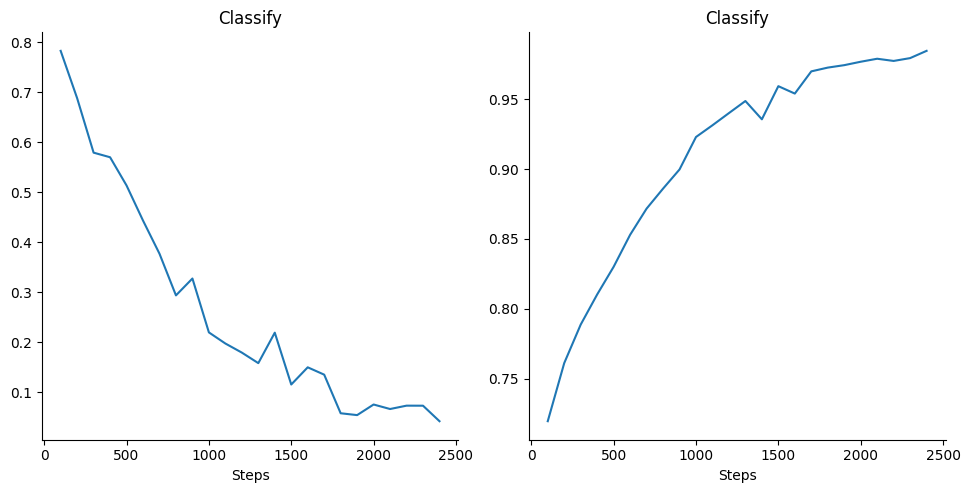

In [ ]:
plot("Classify", CLASSIFY_LOSSES, CLASSIFY_ACCURACIES)

Finally, we evaluate the models on the test set.

In [ ]:
test("Classify", CLASSIFIER, CLASSIFY_DATASETS)

Classify Test Accuracy: 98.53%


# **Part 3 (Total 30 pts)**. Enigma decryption: Decipherer

### Create Models

As mentioned above, we adopt GRU as our base model. The table below shows the architecture parameters we've tested. You can change these parameters or even try other architectures like LSTM.


| Hidden State Dimension | Number of Layers |
|:----------------------:|:----------------:|
| 2048                   | 1                |

#### Guideline

* Goal  
  * The `DECIPHERER` takes labels(i.e., enigma configuration types) and the ciphers as inputs and returns the decrypted message.
  * This task is slightly more challenging than the previous one. Think carefully about how to incorporate the label information together with the input tokens. One possible way would be to use different initial states for each configuration type while training those initial states together with the rest of the model.
  * We recommend you aim for at least 95% accuracy on the test set, as we will use the learned decipherer in the final part of the project.

In [14]:
class Decipherer(nn.Module):
    """ Decipher the input message based on the given enigma configuration.

    Parameters:
     - hidden_size(int): The number of features in the hidden state h.
     - num_layers(int):  The number of recurrent layers.
    """
    def __init__(self, hidden_size: int, num_layers: int):
        super().__init__()
        ############################################
        ################## Part 3 ##################
        # Feel free to modify this part if you want.
        num_characters = len(VOCABULARY_DECIPHER)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.text_embedding = nn.Embedding.from_pretrained(
            torch.eye(num_characters, dtype=torch.float32), freeze=True
        )
        self.rnn = nn.GRU(
            input_size=num_characters,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.init_hidden = nn.Linear(in_features=num_characters, out_features=hidden_size)
        self.linear = nn.Linear(
            in_features=hidden_size, out_features=num_characters
        )
        ############################################
        ############################################
        self.to(device=DEVICE)

    def forward(
        self, labels: torch.Tensor, texts: torch.Tensor
    ) -> torch.Tensor:
        """ Decipher the input message based on the given enigma configuration
        type.

        Parameters:
         - labels: integer tensor containing the configuration type of each
                   input message
         - texts: integer tensor containing the index of each token in the input
                  message

        Returns:
        tensor containing the logits for each deciphered token

        Shape:
         - labels: (batch_size,)
         - texts: (batch_size, sequence_length)
         - output: (batch_size, sequence_length, vocabulary_size)
        """
        ############################################
        ################## Part 3 ##################
        texts = texts.to(DEVICE)
        labels = labels.to(DEVICE)

        onehot = nn.functional.one_hot(labels, num_classes=len(VOCABULARY_DECIPHER)).float()
        hidden = self.init_hidden(onehot).unsqueeze(0).repeat(self.num_layers, 1, 1)
        hidden = hidden.to(DEVICE)

        embed = self.text_embedding(texts)
        rnn, _ = self.rnn(embed, hidden)
        logits = self.linear(rnn)

        return logits

        ############################################
        ############################################


DECIPHERER = Decipherer(2048, 1)

### Train Models

We train the models using the following hyperparameters. You may change these parameters.

| Task | optimizer | learning rate | batch size | max epochs |
|:-:|:-:|:-:|:-:|:-:|
| Decipher | [`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) | 0.0001 | 512 | 5 |

In [ ]:
DECIPHER_LOSSES, DECIPHER_ACCURACIES = train(
    model=DECIPHERER,
    datasets=DECIPHER_DATASETS,
    optimizer_type="Adam",
    learning_rate=0.0004,
    batch_size=512,
    max_epochs=3,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/1024 [00:00<?, ?it/s]

### Results  
Let us plot how the loss and the validation accuracy change throughout the training process.

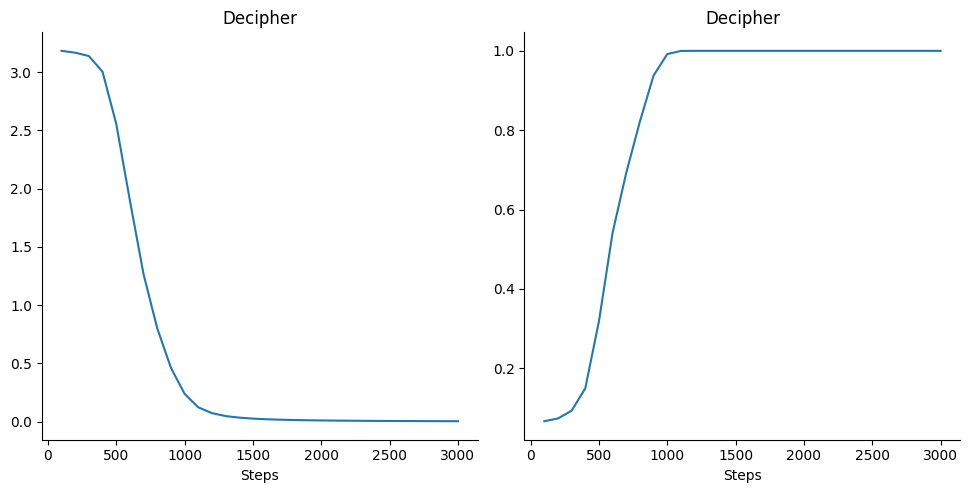

In [ ]:
plot("Decipher", DECIPHER_LOSSES, DECIPHER_ACCURACIES)

Finally, we evaluate the models on the test set.

In [ ]:
test("Decipher", DECIPHERER, DECIPHER_DATASETS)

Decipher Test Accuracy: 100.00%


# **Part 4 (Total 15 pts)**. Enigma decryptor

In this part, you combine your classifier and decipherer to make a full decryptor. You will be given seven ciphers whose original sentences are movie quotes. You need to find out the title of the movie that the quote appears. If you are not familiar with movies, feel free to google them.   

* **Complete the table below**. Consult the sample row we provided for what to write.
* You will get 3 points for each correct movie title.
* However, we will also check the text you deciphered, so do not just randomly guess titles and hope they are correct.

| Index | Cipher | Decrypted | Enigma Configuration Type | Your guess on the original quote | Movie title |
|:-:|:-|:-|:-:|:-|:-:|
| Sample | H'xz ks qtvy. | I'll be bacx. | 0 | I'll be back. | The Terminator |
| 0 | Nhazchs sp'd zfq aau pfph. Ju'b v zyingb qlcylcup,</br>l plrzmach nkeunhngy. O fcdi iunkse. | (your answer) | (your answer) | (your answer) | (your answer) |
| 1 | Vuufj gpq lfan fkui? Yodpng. | (your answer) | (your answer) | (your answer) | (your answer) |
| 2 | Sjmqs ryso. Uresg hai ahf, taao. Ebwj mvep ezzkm</br>bgejftynfalvc. | (your answer) | (your answer) | (your answer) | (your answer) |
| 3 | Ll djp ue lvljmm bprt fvgg rjmc bpcbg. Wznm, lfeo</br>kojblvp zml whwdj qh dmg wqdcs. | (your answer) | (your answer) | (your answer) | (your answer) |
| 4 | Pwckzox, vlbf apxvt, Yipzakal, Eyehsrp, aoenveorv</br>Cgp Vca qb, oo'l cwft etxvem. | (your answer) | (your answer) | (your answer) | (your answer) |


### Guideline  
* Properly **combine your classifier and decipherer** trained in the part 2, 3.
 * We offered a diagram for the overall structure below.
* Properly **process the data**.
  * The form of text that the classifier and the decipherer take as input are **different**. You should appropriately process the ciphers before giving them as input.
    * Classifier dataset: Contains capital letters, punctuation marks, and spaces (e.g., "Ip mffsyjrm oi'q tbip.")
    * Decipherer dataset: Contains only lowercase letters. (e.g., "ipmffsyjrmoiqtbip")
  * Recall that we trained the decipherer using a dataset with texts of length 64. How does this fact affect the decryption of ciphers that are longer than 64 characters? How would you deal with this issue? (You do not have to answer it. This might not be a big problem.)

</br>
<p align="center">
<img src="https://github.com/sisrel/EE214-Fall-2023/blob/main/assets/EEpj3.png?raw=true" alt="EEpj3">
</p>

### Implement the decryptor  

* **Complete the `decrypt` function.**
* You may retrain the classifier and the decipherer with different hyperparameters (e.g., model size, batch size, max epochs, etc) if you want.
* However, **all your codes must be runnable on colab**.  
* You can use the methods [`VOCABULARY_DECIPHER.lookup_token`](https://pytorch.org/text/stable/vocab.html#torchtext.vocab.Vocab.lookup_token) or [`VOCABULARY_DECIPHER.lookup_tokens`](https://pytorch.org/text/stable/vocab.html#torchtext.vocab.Vocab.lookup_tokens) to convert integers back to characters. Feel free to use other methods if you want.

In [15]:
## DO NOT EDIT THIS CELL

CIPHERS = [
    "Nhazchs sp'd zfq aau pfph. Ju'b v zyingb qlcylcup, l plrzmach nkeunhngy. O fcdi iunkse.",
    "Vuufj gpq lfan fkui? Yodpng.",
    "Sjmqs ryso. Uresg hai ahf, taao. Ebwj mvep ezzkm bgejftynfalvc.",
    "Ll djp ue lvljmm bprt fvgg rjmc bpcbg. Wznm, lfeo kojblvp zml whwdj qh dmg wqdcs.",
    "Pwckzox, vlbf apxvt, Yipzakal, Eyehsrp, aoenveorv Cgp Vca qb, oo'l cwft etxvem.",
]


### You may use this function if you want
def finalize(cipher: str, decrypted: str) -> str:
    """ Post process the decrypted message

    Add spaces and punctuation marks and capitalize certain letters to match the
    sentence structure of the given cipher.

    Parameters:
     - cipher: the cipher
     - decrypted: the output of the decipherer converted to lowercase letters

    Returns:
    Decrypted message that has an identical sentence structure with the cipher.
    """
    expected_length = len(re.sub(r"[^a-zA-Z]", "", cipher))
    if expected_length != len(decrypted):
        raise ValueError(
            f"Expected a string of length: {expected_length}. "
            f"Received a string of length: {len(decrypted)}."
        )

    output = ""
    index = 0

    for character in cipher:
      if character.isalpha():
        if character.isupper():
            output += decrypted[index].upper()
        else:
            output += decrypted[index]
        index += 1
      else:
        output += character
    return output

In [43]:
# Feel free to import additional libraries if you need them
def decrypt(cipher: str) -> tuple[int, str]:
    """ Decrypt the cipher.

    Parameters:
     - cipher: the string you need to decrypt

    Returns:
    tuple of an integer and a string (type, decrypted)
     - type: Enigma configuration type used to encrypt the cipher.
             Should be one of 0, 1, 2, and 3.
     - decrypted: Decrypted message.
    """
    ############################### Part 4 ###############################
    ################# Freely design your decryptor here ##################
    pre = "".join(char.lower() for char in cipher if char.isalpha())

    classify = torch.tensor(VOCABULARY_CLASSIFY.lookup_indices(list(cipher)), dtype=torch.long).to(DEVICE)
    decipher = torch.tensor(VOCABULARY_DECIPHER.lookup_indices(list(pre)), dtype=torch.long).to(DEVICE)

    classify = classify.view(1, -1)
    decipher = decipher.view(1, -1)

    classifier = CLASSIFIER(classify, torch.tensor([len(cipher)], dtype=torch.long))
    config = torch.argmax(classifier).item()

    decipher = DECIPHERER(torch.tensor([config]), decipher)
    decipher = torch.argmax(decipher, dim=2).squeeze()
    decipher = VOCABULARY_DECIPHER.lookup_tokens(list(decipher))

    decode = finalize(cipher, decipher)
    return config, decode
    ######################################################################
    ######################################################################

In [44]:
# DO NOT MODIFY THIS CELL

def print_decrypt_results():
    for index, cipher in enumerate(CIPHERS):
        if index > 0:
            print()
        enigma_type, decrypted = decrypt(cipher)
        print(f"Cipher {index}: ", cipher)
        print("Decrypted:", decrypted)
        print("Enigma configuration type:", enigma_type)


print_decrypt_results()

Cipher 0:  Nhazchs sp'd zfq aau pfph. Ju'b v zyingb qlcylcup, l plrzmach nkeunhngy. O fcdi iunkse.
Decrypted: Because he's not our hero. He's a silent guardian, a watchful protector. A dark kniyod.
Enigma configuration type: 3

Cipher 1:  Vuufj gpq lfan fkui? Yodpng.
Decrypted: After all this time? Always.
Enigma configuration type: 0

Cipher 2:  Sjmqs ryso. Uresg hai ahf, taao. Ebwj mvep ezzkm bgejftynfalvc.
Decrypted: Carpe diem. Seize the day, boys. Make your lives extraordinary.
Enigma configuration type: 0

Cipher 3:  Ll djp ue lvljmm bprt fvgg rjmc bpcbg. Wznm, lfeo kojblvp zml whwdj qh dmg wqdcs.
Decrypted: Do not go gentle into that good night. Rage, rage against the dying of the light.
Enigma configuration type: 1

Cipher 4:  Pwckzox, vlbf apxvt, Yipzakal, Eyehsrp, aoenveorv Cgp Vca qb, oo'l cwft etxvem.
Decrypted: Jessica, only child, Illinois, Chicago, classmate Kim Jin mo, he's your cousin.
Enigma configuration type: 2


#References  
[1] "A Corpus and Cloze Evaluation for Deeper Understanding of Commonsense Stories". Nasrin Mostafazadeh, Nathanael Chambers, Xiaodong He, Devi Parikh, Dhruv Batra, Lucy Vanderwende, Pushmeet Kohli and James Allen. In Proceedings of the 2016 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies (NAACL HLT), 2016